In [2]:
library(microbiome)
library(phyloseq); packageVersion("phyloseq")
library("tidyverse")
library("dplyr")
library(vegan)
#library("lubridate")
library('PCAtools')
library("GGally")
library("ggpmisc")
library("speedyseq")
library(patchwork)
library("pairwiseAdonis"); packageVersion("pairwiseAdonis")


[1] ‘1.46.0’

[1] ‘0.4.1’

In [4]:
#import data from r.data
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_counts_4_analysis.RData")
load("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/data/POR_taxo_4_analysis.RData")


In [5]:
#load metadata
meta = read.csv ("/Users/stephanie.rosales/Documents/omics_projects/POR_16S/CoralPersistence/metadata/POR_combo_meta.csv",
row.names=1, header = T)%>%
  mutate(
    Month = factor(Month, levels = month.name)
  ) %>%
  arrange(Month) %>%
arrange(collection_date)

head(meta, n=2)

,collection_date,Speed.cm.s.,Bearing.degrees.,Velocity.N.cm.s.,Velocity.E.cm.s.,Temperature.C.,reef,Genotype,Fragment_number,Month,⋯,cluster_depth,depth,Year.y,Month.y,Lat_decimal,Long_decimal,avgchla_mgm.3,sdchla_mgm.3,avgSST_degC,sdSST_degC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bagnumber-584,1-Mar-19,5.331549,147.0395,-1.81184,-0.7369632,26.09619,pr,CN2,3,March,⋯,-15.7,15.7,2019,March,24.985,-80.416,0.3999531,0.163012,25.99442,0.2483825
bagnumber-585,1-Mar-19,5.331549,147.0395,-1.81184,-0.7369632,26.09619,pr,CN2,4,March,⋯,-15.7,15.7,2019,March,24.985,-80.416,0.3999531,0.163012,25.99442,0.2483825


In [6]:
## taxonomy and counts as matrices
taxo_mat <- as.matrix(POR_taxo_4_analysis)
count_mat <- as.matrix(POR_counts_4_analysis)

In [7]:
#make phyloseq object
ASV <- otu_table(as.matrix(POR_counts_4_analysis), 
                 taxa_are_rows = T)
TAX <- tax_table(taxo_mat)
SAMP <- sample_data(meta)

ps <- phyloseq(ASV, TAX, SAMP)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27534 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27534 taxa by 7 taxonomic ranks ]:
taxa are rows

In [8]:
#list of ASVs that Blasted as Eukaryote
euk_asvs <- c("ASV_10673","ASV_10883",	"ASV_11806","ASV_12333",	"ASV_12335",	"ASV_13587",	"ASV_14757",	"ASV_15238",	"ASV_15259",	"ASV_16364",	"ASV_16936",	"ASV_17406",	"ASV_18096",	"ASV_18375",	"ASV_18682",	"ASV_19529",	"ASV_19795",	"ASV_19953",	"ASV_2",	"ASV_20640",	"ASV_2100",	"ASV_22284",	"ASV_22692",	"ASV_23038",	"ASV_23144",	"ASV_24135",	"ASV_24243",	"ASV_27014",	"ASV_29665",	"ASV_30547",	"ASV_30626",	"ASV_30884",	"ASV_4161",	"ASV_4498",	"ASV_476",	"ASV_4797",	"ASV_4966",	"ASV_5018",	"ASV_5118",	"ASV_5154",	"ASV_6282",	"ASV_653",	"ASV_6843",	"ASV_7264",	"ASV_7427",	"ASV_8",	"ASV_9248",	"ASV_9692")
allTaxa = taxa_names(ps)
allTaxa <- allTaxa[!(allTaxa %in% euk_asvs)]
ps_fill_euk = prune_taxa(allTaxa, ps)
# new phyloseq object with removed eukaryotes 
ps_fill_euk

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 363 samples ]:
sample_data() Sample Data:        [ 363 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [9]:
#filter samples only sampled once
extras=c("apal_cf_gCN2_cl6_fr5_AH_2019-09-25",
  "apal_ndr_gCN2_cl15_fr4_AH_2019-11-19",
  "apal_pr_gCN2_cl75_fr6_AH_2019-11-18",
  "apal_ndr_gCN4_cl32_frB_AH_2019-11-19",
  "apal_pr_gCN4_cl98_fr4_AH_2019-09-26",
  "apal_cf_gHS1_cl15_frB_AH_2019-11-19",
  "apal_pr_gHS1_cl106_fr7_AH_2019-11-18",
  "apal_pr_gHS1_cl108_fr3_AH_2019-11-18",
  "apal_ndr_gML2_cl18_fr6_AH_2019-11-19",
  "apal_ndr_gCN1_cl17_fr4_AH_2019-09-25",
  "apal_pr_gCN4_cl98_fr4_AH_2019-09-26",
  "apal_pr_gHS1_cl106_fr6_AH_2019-07-02",
  "apal_pr_gHS1_cl106_fr7_AH_2019-03-01",
  "apal_pr_gHS1_cl106_fr7_AH_2019-11-18",
  "apal_pr_gHS1_cl108_fr3_AH_2019-11-18",
  "apal_pr_gML2_cl58_frA_AH_2019-11-18",
        "apal_pr_gCN2_cl81_fr6_AH_2019-09-26",
        "apal_pr_gCN2_cl81_fr4_AH_2019-09-26",
        "apal_ndr_gCN4_cl38_frB_AH_2019-11-19",
        "apal_ndr_gCN4_cl38_fr5_AH_2019-11-19",
        "apal_ndr_gCN1_cl17_fr4_AH_2019-09-25")


ps_fill_samp = subset_samples(ps_fill_euk, !sample_ID %in% extras)
ps_fill_samp

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 346 samples ]:
sample_data() Sample Data:        [ 346 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [10]:
#merge samples from same cluster
ps_merge = merge_samples2(ps_fill_samp, "geno_clus")
ps_merge

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 27486 taxa and 124 samples ]:
sample_data() Sample Data:        [ 124 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 27486 taxa by 7 taxonomic ranks ]:
taxa are rows

In [11]:
#filter to remove noise from data
ps_fill = filter_taxa(ps_merge, function(x) sum(x > 10) > (0.15*length(x)), TRUE)
ps_fill


phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 464 taxa and 124 samples ]:
sample_data() Sample Data:        [ 124 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 464 taxa by 7 taxonomic ranks ]:
taxa are rows

In [12]:
# transform data into clr and ordinate
ps_clr <- microbiome::transform(ps_fill, 'clr')
psr_clr_ord <- ordinate(ps_clr, "RDA", "euclidean")

### Dispersion

In [13]:
#create distance matrix
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

#run dispersion analysis for genotype
mod_geno <- betadisper(ps_veg, sample_data(ps_clr)$Genotype, type ="centroid")

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
mod_dist= as.data.frame(mod_geno$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_geno)


#results: CN4-CN2, and ML2-HS1 are not different


[1] 124   1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
             diff       lwr        upr     p adj
CN4-CN2  0.728418 -2.708568  4.1654041 0.9457955
HS1-CN2 -3.436006 -6.640685 -0.2313269 0.0305031
ML2-CN2 -4.858063 -8.332613 -1.3835133 0.0022334
HS1-CN4 -4.164424 -7.622389 -0.7064590 0.0113664
ML2-CN4 -5.586481 -9.295935 -1.8770271 0.0008309
ML2-HS1 -1.422057 -4.917361  2.0732458 0.7144183


In [14]:
#dispersion
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

#run dispersion analysis for reef
mod_reef <- betadisper(ps_veg, sample_data(ps_clr)$reef, type ="centroid")

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)

mod_dist= as.data.frame(mod_reef$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_reef)




[1] 124   1

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
             diff       lwr      upr     p adj
ndr-cf -0.8253487 -3.955668 2.304971 0.8063439
pr-cf  -2.1743902 -5.318203 0.969423 0.2324270
pr-ndr -1.3490416 -4.155023 1.456940 0.4909563


In [15]:
#distances between
ps_veg <- vegdist(otu_table(t(ps_clr)), method ="euclidean")

#run dispersion analysis for month
mod_month <- betadisper(ps_veg, sample_data(ps_clr)$Samp_trip, type ="centroid")
#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
mod_month

mod_dist= as.data.frame(mod_month$distances)
dim(mod_dist)
mod_dist_df=cbind(sample_data(ps_clr), mod_dist) 
head(mod_dist)

#test the pair-wise comparisons for Multivariate Homogeneity Of Groups Dispersions (Variances)
TukeyHSD(mod_month)



	Homogeneity of multivariate dispersions

Call: betadisper(d = ps_veg, group = sample_data(ps_clr)$Samp_trip,
type = "centroid")

No. of Positive Eigenvalues: 123
No. of Negative Eigenvalues: 0

Average distance to centroid:
Trip_2 Trip_3 Trip_4 Trip_5 
 44.86  49.53  45.92  46.82 

Eigenvalues for PCoA axes:
(Showing 8 of 123 eigenvalues)
PCoA1 PCoA2 PCoA3 PCoA4 PCoA5 PCoA6 PCoA7 PCoA8 
33838 24564 12938 11487  8345  7986  6980  5792 

[1] 124   1

,mod_month$distances
,<dbl>
ML2_78_cf_Trip_3,42.18045
CN4_35_cf_Trip_3,45.08853
CN4_25_cf_Trip_3,52.05416
HS1_18_cf_Trip_3,44.80135
HS1_17_cf_Trip_3,50.33733
HS1_15_cf_Trip_3,47.02555


  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = distances ~ group, data = df)

$group
                    diff       lwr        upr     p adj
Trip_3-Trip_2  4.6772189  1.222049 8.13238895 0.0033023
Trip_4-Trip_2  1.0681718 -2.576614 4.71295779 0.8706551
Trip_5-Trip_2  1.9609380 -1.580816 5.50269169 0.4755551
Trip_4-Trip_3 -3.6090471 -7.278195 0.06010092 0.0556745
Trip_5-Trip_3 -2.7162809 -6.283100 0.85053861 0.1997344
Trip_5-Trip_4  0.8927662 -2.858029 4.64356158 0.9254615


### PERMANOVA

In [16]:
ps_ra_ad =  subset_samples(ps_clr, cluster_depth!= "NA")
ps_ra_ad 
ps_ra_ad_meta= data.frame(sample_data(ps_ra_ad))
head(ps_ra_ad_meta)
dim(ps_ra_ad_meta)
#ps_ra_ad
#distances between
ps_veg_ad = dist(otu_table(t(ps_ra_ad)), method ="euclidean")
#  adonis(formula = abund_table ~ ., data = meta_table) 

adonis2(ps_veg_ad~Samp_trip*Genotype*reef, 
       data =ps_ra_ad_meta, 
         method = "euclidean", permutations = 999)

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 464 taxa and 123 samples ]:
sample_data() Sample Data:        [ 123 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 464 taxa by 7 taxonomic ranks ]:
taxa are rows

,collection_date,Speed.cm.s.,Bearing.degrees.,Velocity.N.cm.s.,Velocity.E.cm.s.,Temperature.C.,reef,Genotype,Fragment_number,Month,⋯,cluster_depth,depth,Year.y,Month.y,Lat_decimal,Long_decimal,avgchla_mgm.3,sdchla_mgm.3,avgSST_degC,sdSST_degC
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,⋯,<dbl>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,ML2,NA,June,⋯,-20.9,20.9,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
CN4_35_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,CN4,NA,June,⋯,-17.9,17.9,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
CN4_25_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,CN4,A,June,⋯,-20.8,20.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_18_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-18.8,18.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_17_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-17.8,17.8,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026
HS1_15_cf_Trip_3,25-Jun-19,4.852118,122.786,0.9382899,3.174028,30.40801,cf,HS1,NA,June,⋯,-17.6,17.6,2019,June,25.221,-80.21,1.792092,0.3763544,29.63623,0.5081026


[1] 123  58

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Samp_trip,3,25417.95,0.08502143,4.296836,0.001
Genotype,3,11986.15,0.04009290,2.026226,0.001
reef,2,19285.74,0.06450957,4.890302,0.001
Samp_trip:Genotype,9,18527.08,0.06197189,1.043984,0.264
Samp_trip:reef,6,22347.75,0.07475180,1.888913,0.001
Genotype:reef,6,14703.86,0.04918345,1.242823,0.014
Samp_trip:Genotype:reef,15,32887.72,0.11000732,1.111916,0.029
Residual,78,153803.14,0.51446164,NA,NA
Total,122,298959.39,1.00000000,NA,NA


In [17]:
pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$reef, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$Samp_trip, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairwise.adonis(ps_veg_ad, phyloseq::sample_data(ps_ra_ad)$Genotype, sim.method = "euclidean",
                p.adjust.m = "bonferroni")

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
cf vs ndr,1,6224.089,2.594378,0.03300972,0.001,0.003,*
cf vs pr,1,7238.240,3.141944,0.04072939,0.001,0.003,*
ndr vs pr,1,14748.064,6.436718,0.06674552,0.001,0.003,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Trip_3 vs Trip_4,1,9299.245,3.871819,0.06360610,0.001,0.006,*
Trip_3 vs Trip_5,1,8841.889,3.618502,0.05599792,0.001,0.006,*
Trip_3 vs Trip_2,1,9909.808,4.280435,0.06178418,0.001,0.006,*
Trip_4 vs Trip_5,1,7004.364,3.073654,0.05385417,0.002,0.012,.
Trip_4 vs Trip_2,1,9192.156,4.282750,0.06876303,0.001,0.006,*
Trip_5 vs Trip_2,1,6452.861,2.927963,0.04509556,0.001,0.006,*


pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ML2 vs CN4,1,2372.358,0.9843328,0.01893518,0.435,1.000,
ML2 vs HS1,1,3934.442,1.8012458,0.02962515,0.004,0.024,.
ML2 vs CN2,1,3364.987,1.4052594,0.02326386,0.046,0.276,
CN4 vs HS1,1,4105.332,1.6912502,0.02741475,0.006,0.036,.
CN4 vs CN2,1,3960.253,1.5034173,0.02444445,0.050,0.300,
HS1 vs CN2,1,5848.490,2.4248784,0.03443213,0.001,0.006,*


## PCA correlation

In [18]:
ps_ra_df=as.data.frame(otu_table(ps_clr))
ps_ra_meta= as(sample_data(ps_clr), "data.frame")


In [19]:
  p <- pca(ps_ra_df, metadata =ps_ra_meta, 
           removeVar = 0.1)

-- removing the lower 10% of variables based on variance



Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“Samp_trip is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“reef is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in eigencorplot(p, metavars = c("Si.uM.", "NO2.uM.", "N.N.uM.", :
“Genotype is not numeric - please check the source data as non-numeric variables will be coerced to numeric”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(xvals[, i], yvals[, j], use = corUSE, method = corFUN):
“Cannot compute exact p-value with ties”
Warning message in cor.test.def

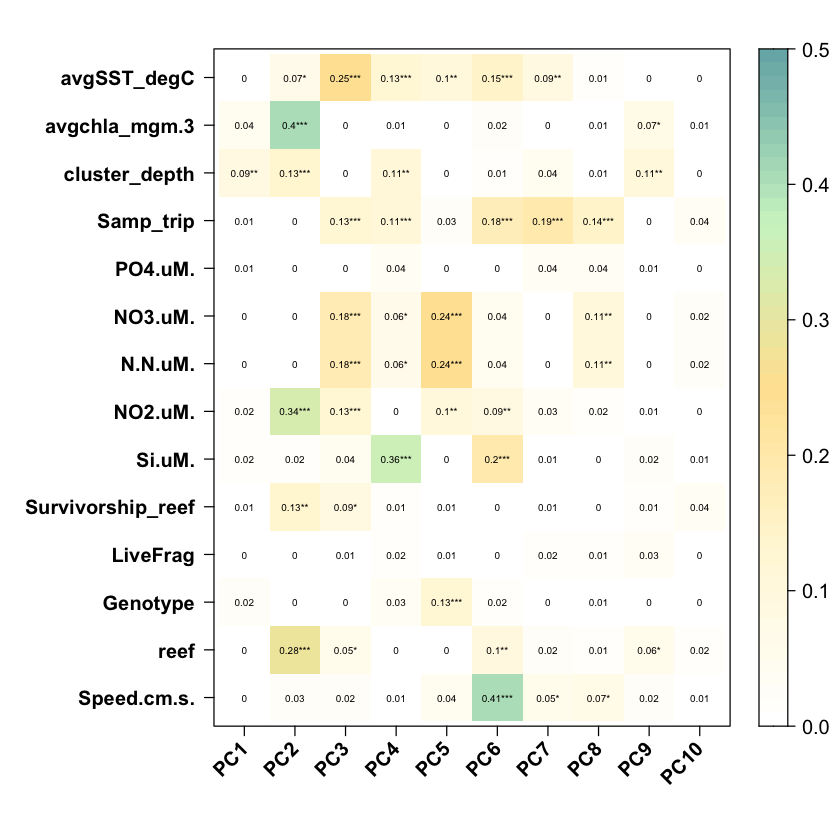

In [20]:
 eigencorplot(p,
    metavars = c('Si.uM.', 'NO2.uM.', 'N.N.uM.', 'NO3.uM.', 'PO4.uM.', "Samp_trip", "avgchla_mgm.3", "reef", "Genotype",
                "Speed.cm.s.", "avgSST_degC", 'cluster_depth', "Survivorship_reef",
                "LiveFrag"),
              col = c('white', 'cornsilk1', "#FFE4A1",  '#CFF3CA', "#77B3B5"),
    cexCorval = 0.5,
    fontCorval = 0.5,
    cexTitleX = 4,
    
    #posLab = 'all',
    rotLabX = 45,
    scale = TRUE,
    plotRsquared = TRUE,
    corFUN = 'spearman',
    corUSE = 'pairwise.complete.obs',
    corMultipleTestCorrection = 'BH')

### Model selection

In [21]:
#remove samples with NA values (one found)
ps_fill_ad =  subset_samples(ps_fill, cluster_depth!= "NA")
ps_fill_ad

phyloseq-class experiment-level object
otu_table()   OTU Table:          [ 464 taxa and 123 samples ]:
sample_data() Sample Data:        [ 123 samples by 58 sample variables ]:
tax_table()   Taxonomy Table:     [ 464 taxa by 7 taxonomic ranks ]:
taxa are rows

In [22]:
ps_ad_clr<- microbiome::transform(ps_fill_ad, 'clr')

In [23]:
ps_clr_ad_meta1= ps_ra_ad_meta %>% select("Genotype", "Samp_trip", "reef","Survivorship",'Speed.cm.s.', 'NO2.uM.', 'N.N.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "avgchla_mgm.3", "Temperature.C.","cluster_depth")


cor(ps_clr_ad_meta1[4:14])

,Survivorship,Speed.cm.s.,NO2.uM.,N.N.uM.,NO3.uM.,PO4.uM.,Si.uM.,avgSST_degC,avgchla_mgm.3,Temperature.C.,cluster_depth
Survivorship,1.00000000,0.2020492682,-0.1836833,0.084967901,0.088026513,-0.1308039,0.06845218,0.02197782,0.16307450,0.12331186,0.5141129492
Speed.cm.s.,0.20204927,1.0000000000,-0.5226575,-0.526369425,-0.523932358,0.2161646,0.56575261,0.09900841,-0.10532626,0.23210342,-0.0008218181
NO2.uM.,-0.18368333,-0.5226575253,1.0000000,0.600955150,0.592725527,0.2118500,-0.40071463,0.67925128,0.34020161,0.48175219,0.1747620009
N.N.uM.,0.08496790,-0.5263694251,0.6009551,1.000000000,0.999946523,-0.2414270,-0.25695181,0.58228370,0.09957937,0.50901685,0.0086891323
NO3.uM.,0.08802651,-0.5239323584,0.5927255,0.999946523,1.000000000,-0.2464721,-0.25365364,0.57778615,0.09594188,0.50664161,0.0067718459
PO4.uM.,-0.13080390,0.2161646280,0.2118500,-0.241427008,-0.246472133,1.0000000,0.37463374,0.13900451,-0.29248684,0.27188880,-0.1817348386
Si.uM.,0.06845218,0.5657526055,-0.4007146,-0.256951805,-0.253653641,0.3746337,1.00000000,-0.04533715,-0.34968432,0.41990152,-0.2475579186
avgSST_degC,0.02197782,0.0990084123,0.6792513,0.582283696,0.577786146,0.1390045,-0.04533715,1.00000000,0.27526552,0.86287125,0.0730679677
avgchla_mgm.3,0.16307450,-0.1053262577,0.3402016,0.099579366,0.095941878,-0.2924868,-0.34968432,0.27526552,1.00000000,0.07966301,0.7674665590
Temperature.C.,0.12331186,0.2321034185,0.4817522,0.509016849,0.506641614,0.2718888,0.41990152,0.86287125,0.07966301,1.00000000,-0.0110588102


In [24]:

ps_clr_ad_meta= data.frame(sample_data(ps_fill_ad))

#remove co-variate
ps_clr_ad_meta2 = ps_clr_ad_meta %>% select('NO2.uM.', 'NO3.uM.', 'PO4.uM.', 'Si.uM.',
                "Speed.cm.s.", "avgSST_degC", "cluster_depth", "Survivorship")

head(ps_clr_ad_meta2)
dim(ps_clr_ad_meta2)

,NO2.uM.,NO3.uM.,PO4.uM.,Si.uM.,Speed.cm.s.,avgSST_degC,cluster_depth,Survivorship
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ML2_78_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-20.9,0.3571429
CN4_35_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.9,0.6428571
CN4_25_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-20.8,0.6428571
HS1_18_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-18.8,0.7619048
HS1_17_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.8,0.7619048
HS1_15_cf_Trip_3,0.032,0.861,0.0685,0.706,4.852118,29.63623,-17.6,0.7619048


[1] 123   8

In [25]:
mod0 <- rda(otu_table(t(ps_ad_clr)) ~ 1, ps_clr_ad_meta2)
mod1 <- rda(otu_table(t(ps_ad_clr)) ~ ., ps_clr_ad_meta2)
m <- ordistep(mod0, scope = formula(mod1), perm.max = 200, direction ="both")
m


Start: otu_table(t(ps_ad_clr)) ~ 1 

                Df    AIC      F Pr(>F)   
+ NO2.uM.        1 957.92 4.9948  0.005 **
+ avgSST_degC    1 958.60 4.2940  0.005 **
+ cluster_depth  1 958.98 3.9069  0.005 **
+ NO3.uM.        1 960.01 2.8727  0.005 **
+ Speed.cm.s.    1 960.22 2.6582  0.005 **
+ Si.uM.         1 960.85 2.0289  0.010 **
+ Survivorship   1 961.50 1.3817  0.065 . 
+ PO4.uM.        1 961.57 1.3057  0.070 . 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Step: otu_table(t(ps_ad_clr)) ~ NO2.uM. 

          Df    AIC      F Pr(>F)   
- NO2.uM.  1 960.89 4.9948  0.005 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                Df    AIC      F Pr(>F)   
+ avgSST_degC    1 956.27 3.6136  0.005 **
+ cluster_depth  1 956.43 3.4504  0.005 **
+ NO3.uM.        1 956.64 3.2359  0.005 **
+ Speed.cm.s.    1 956.72 3.1634  0.005 **
+ Si.uM.         1 958.42 1.4740  0.035 * 
+ PO4.uM.        1 958.48 1.4131  0.045 * 
+ Survivorship   1 958

Call: rda(formula = otu_table(t(ps_ad_clr)) ~ NO2.uM. + avgSST_degC +
Speed.cm.s. + cluster_depth + Survivorship + PO4.uM. + Si.uM. +
NO3.uM., data = ps_clr_ad_meta2)

                Inertia Proportion Rank
Total         2450.4868     1.0000     
Constrained    407.3740     0.1662    8
Unconstrained 2043.1128     0.8338  114
Inertia is variance 

Eigenvalues for constrained axes:
  RDA1   RDA2   RDA3   RDA4   RDA5   RDA6   RDA7   RDA8 
136.78  77.05  51.75  50.95  34.49  23.15  18.33  14.87 

Eigenvalues for unconstrained axes:
   PC1    PC2    PC3    PC4    PC5    PC6    PC7    PC8 
263.53 108.89  78.97  63.00  54.50  42.28  39.39  37.34 
(Showing 8 of 114 unconstrained eigenvalues)


In [26]:
vif.cca(m)

NO2.uM.   avgSST_degC   Speed.cm.s. cluster_depth  Survivorship 
    15.145171     13.448424     11.681911      2.358331      2.034539 
      PO4.uM.        Si.uM.       NO3.uM. 
     2.554722      2.132781      5.780194

In [27]:
anova(m,  by="term")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
NO2.uM.,1,97.14401,5.420365,0.001
avgSST_degC,1,68.79493,3.838565,0.001
Speed.cm.s.,1,66.88822,3.732176,0.001
cluster_depth,1,53.94629,3.010052,0.001
Survivorship,1,29.72490,1.658567,0.014
PO4.uM.,1,31.88106,1.778874,0.007
Si.uM.,1,29.49239,1.645593,0.023
NO3.uM.,1,29.50225,1.646143,0.013
Residual,114,2043.11279,NA,NA


In [28]:
anova(m, by="margin")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
NO2.uM.,1,52.21189,2.913278,0.001
avgSST_degC,1,38.47789,2.146959,0.003
Speed.cm.s.,1,41.21363,2.299606,0.001
cluster_depth,1,49.70921,2.773636,0.001
Survivorship,1,24.91655,1.390274,0.053
PO4.uM.,1,31.52586,1.759055,0.010
Si.uM.,1,34.76062,1.939546,0.005
NO3.uM.,1,29.50225,1.646143,0.013
Residual,114,2043.11279,NA,NA


In [29]:
anova(m)

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
Model,8,407.374,2.841292,0.001
Residual,114,2043.113,NA,NA


In [30]:
rda_veg=rda(otu_table(t(ps_ad_clr))  ~ NO2.uM. + NO3.uM. + PO4.uM. + Si.uM. +
                Speed.cm.s. +  avgSST_degC +  cluster_depth, data = ps_clr_ad_meta2, scale = TRUE)

In [31]:
 anova(rda_veg, by="axis")

,Df,Variance,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
RDA1,1,25.484971,7.4383057,0.001
RDA2,1,13.663742,3.9880402,0.001
RDA3,1,9.130458,2.6649095,0.014
RDA4,1,8.329072,2.4310085,0.014
RDA5,1,5.901164,1.7223743,0.099
RDA6,1,4.265138,1.2448671,0.290
RDA7,1,3.214804,0.9383056,0.528
Residual,115,394.010651,NA,NA


In [32]:
envfit(rda_veg, ps_clr_ad_meta1, na.rm = TRUE, permutations = 999)


***VECTORS

                   RDA1     RDA2     r2 Pr(>r)    
Survivorship    0.82421 -0.56629 0.0071  0.666    
Speed.cm.s.     0.48255 -0.87587 0.0813  0.008 ** 
NO2.uM.        -0.92655 -0.37618 0.4745  0.001 ***
N.N.uM.        -0.20248 -0.97929 0.2141  0.001 ***
NO3.uM.        -0.18706 -0.98235 0.2127  0.001 ***
PO4.uM.        -0.74141  0.67106 0.0156  0.416    
Si.uM.          0.90376 -0.42805 0.1015  0.003 ** 
avgSST_degC    -0.43397 -0.90093 0.7158  0.001 ***
avgchla_mgm.3  -0.99982 -0.01916 0.4239  0.001 ***
Temperature.C. -0.29384 -0.95585 0.5649  0.001 ***
cluster_depth  -0.92138  0.38867 0.3095  0.001 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Permutation: free
Number of permutations: 999

***FACTORS:

Centroids:
                   RDA1    RDA2
GenotypeCN2     -0.0667  0.2365
GenotypeCN4     -0.1323 -0.2159
GenotypeHS1      0.0687 -0.1181
GenotypeML2      0.1348  0.0648
Samp_tripTrip_2  0.7536  1.6231
Samp_tripTrip_3 -0.4168 -1.8519
Samp_tripTrip